In [1]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
from robo_trader.strategies.simple_reversal_strategy import SimpleReversalStrategy, SimpleReversalSettings
import json
import matplotlib.pyplot as plt

In [2]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
#SYMBOL = "MSFT"

train_since = pd.to_datetime('2024-03-11').tz_localize('UTC')
start_date = pd.to_datetime('2024-04-11').tz_localize('UTC')
end_date = pd.to_datetime('2024-05-11').tz_localize('UTC')
period = 168

feed = YFinanceFeed(interval = '1h')

settings = SimpleReversalSettings(
    sma_period=20,
    rsi_period=14,
    rsi_overbought=60,
    position_size=0.25,
    trailing_stop=0.01,
    take_profit=None
)
strategy = SimpleReversalStrategy(settings)
trader = Trader(SYMBOL, 1000, feed, strategy)

In [3]:
# Run the backtest
portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 25.0% of the cash (£250.0)
    Creating MARKET BUY order for BTC-GBP at 56225.5 with quantity 0.0044285955660687765, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for BTC-GBP at 56225.5 with quantity 0.0044285955660687765, total cost £249.996 and transaction cost £0.996
        Bought 0.0044285955660687765 BTC-GBP at 56225.5 on 11/04/2024 10:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 56225.5 with quantity 0.0044285955660687765, trail 0.01, limit None, stop None, take_profit None
    Updated trailing stop to 55850.807460937496
Request to open long position on BTC-GBP
    Already long on BTC-GBP
    Executing TRAILING_STOP SELL order for BTC-GBP at 55839.375152343746 with quantity 0.0044285955660687765, total cost £248.2791692485674 and transaction cost £0.9891600368468821
        Sold 0.0044285955660687765 BTC-GBP at 55839.375152343746 on 11/04/2024 1

Win Rate: 0.26
Initial Value: 1000.00
Final Value: 918.51
Portfolio Return: -0.0815
Asset Return: -0.1370


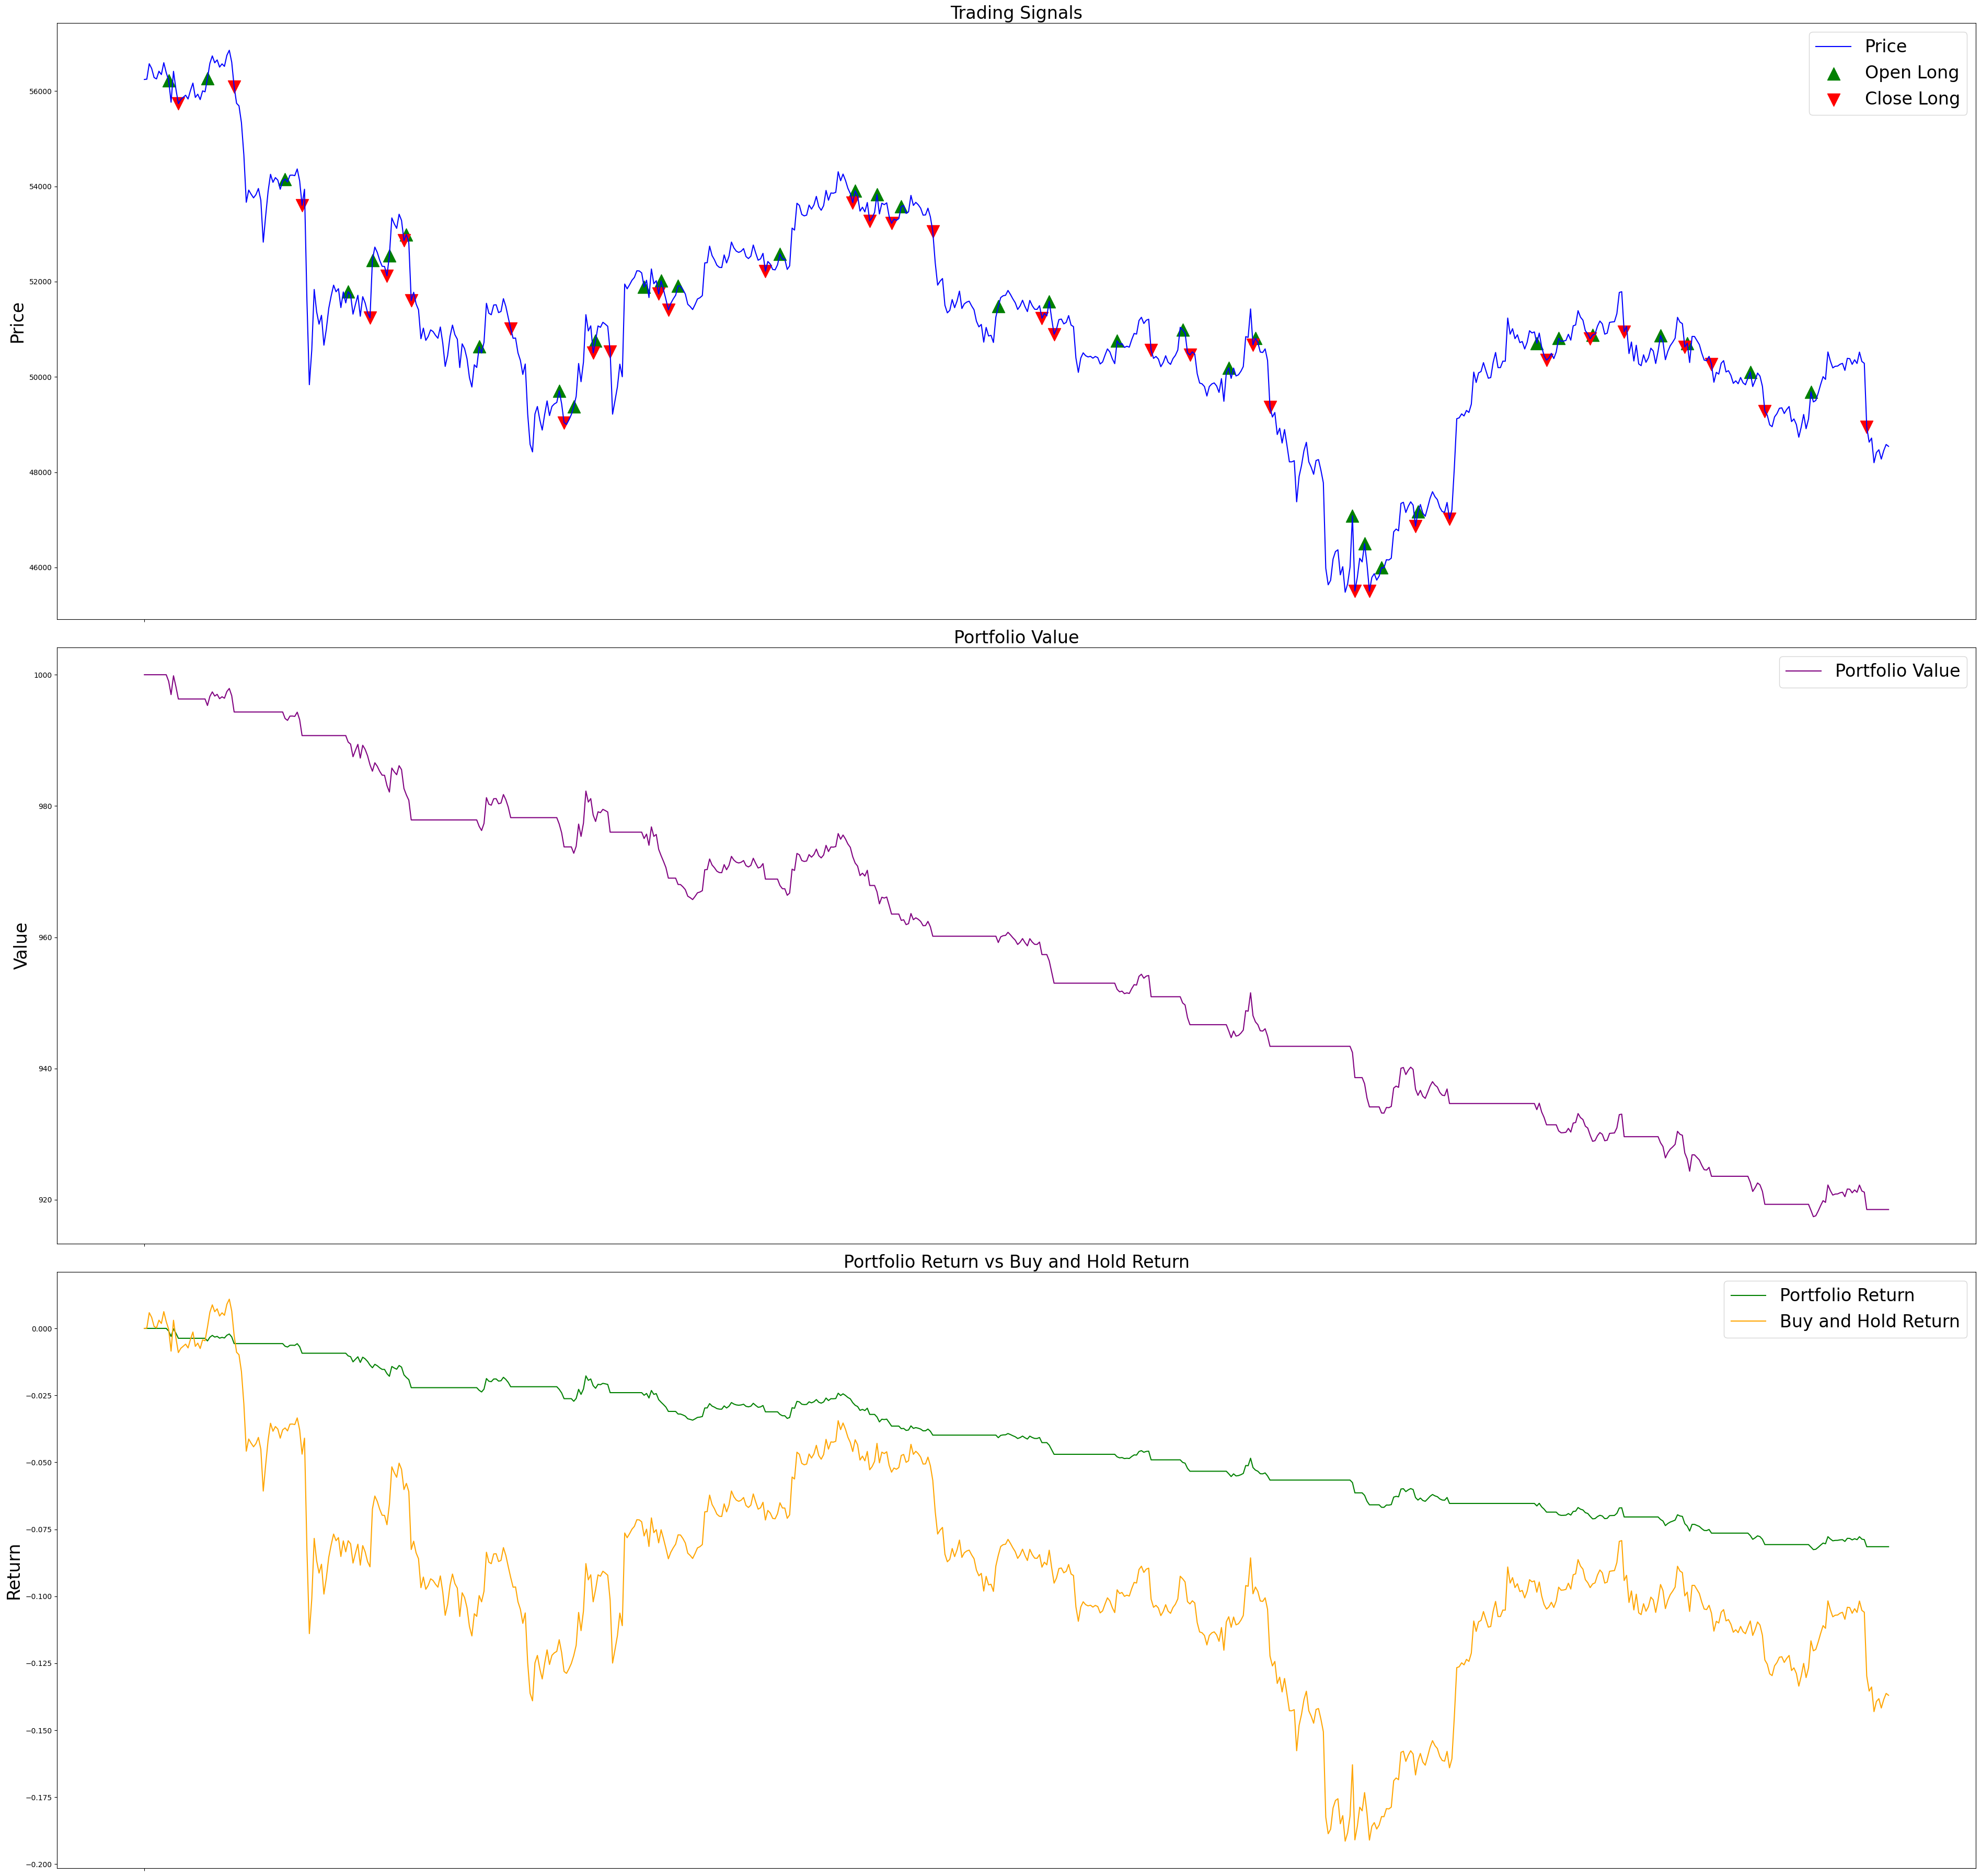

In [4]:
portfolio.plot_performance()